# T5 Fine-tuning


## Import Libraries

In [25]:
# pip install -qqq --upgrade -r requirements.txt

In [26]:
# General libraries
import os
import csv
from dotenv import load_dotenv
load_dotenv()
import os as os_module

# Dataset libraries
from datasets import load_dataset, DatasetDict

# Data manipulation
import pandas as pd
import numpy as np

# Transformers libraries
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback
)

# Visualization
import matplotlib.pyplot as plt
from IPython.display import Image, display

# PyTorch for deep learning
import torch

# Evaluation
from rouge_score import rouge_scorer, scoring

# Hyper parameters tuning
import optuna
from optuna.trial import TrialState

#Hugging Face Hub
import huggingface_hub
from huggingface_hub import login
login(os.getenv("HUGGINGFACE_HUB_TOKEN"))

## Load dataset

In [27]:
def hf_load_dataset(dataset_id, split="train"):
    dataset = load_dataset(dataset_id, split=split)
    return dataset

In [28]:
def split_dataset(
        dataset, test_size=0.1, 
        validation_size=0.1, 
        seed=42
    ):
    datasets_train_test = dataset.train_test_split(test_size=test_size, seed=seed)
    datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=validation_size)
    dataset_split = DatasetDict({
        "train": datasets_train_validation["train"],
        "validation": datasets_train_validation["test"],
        "test": datasets_train_test["test"]
    })

    return dataset_split

## Load Model and Tokenizer

In [29]:
def load_model(model_name):
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.gradient_checkpointing_enable()
    return model

In [30]:
def load_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

## Dataset Preprocess

In [31]:
def preprocess_and_tokenize(
    dataset_split,
    tokenizer,
    input_col,
    target_col,
    input_max_length,
    target_max_length
):
    def preprocess_function(examples):
        inputs = ["summarize: " + (doc or "") for doc in examples[input_col]]

        model_inputs = tokenizer(
            inputs,
            max_length=input_max_length,
            truncation=True,
            padding="max_length",
        )

        labels = tokenizer(
            text_target=[(s or "") for s in examples[target_col]],
            max_length=target_max_length,
            truncation=True,
            padding="max_length",
        )

        labels_ids = labels["input_ids"]
        labels_ids = [
            [(t if t != tokenizer.pad_token_id else -100) for t in seq]
            for seq in labels_ids
        ]
        model_inputs["labels"] = labels_ids
        return model_inputs

    return dataset_split.map(
        preprocess_function,
        batched=True,
        remove_columns=dataset_split["train"].column_names
    )


In [32]:
class GPUMemoryTrackerCallback(TrainerCallback):
    def __init__(self, output_dir: str, log_every_n_steps: int = 10):
        self.output_dir = output_dir
        self.log_every_n_steps = log_every_n_steps
        self.rows = []
        self.csv_path = os.path.join(output_dir, "gpu_memory.csv")
        self.png_path = os.path.join(output_dir, "gpu_memory.png")

    def _sample(self, step: int):
        if not torch.cuda.is_available():
            return

        torch.cuda.synchronize()
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved  = torch.cuda.memory_reserved()  / 1024**3
        max_alloc = torch.cuda.max_memory_allocated() / 1024**3

        self.rows.append((step, allocated, reserved, max_alloc))

    def on_train_begin(self, args, state, control, **kwargs):
        os.makedirs(self.output_dir, exist_ok=True)
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        self._sample(step=0)

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.log_every_n_steps == 0:
            self._sample(step=state.global_step)

    def on_train_end(self, args, state, control, **kwargs):
        self._sample(step=state.global_step)

        with open(self.csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["step", "allocated_gb", "reserved_gb", "max_allocated_gb"])
            w.writerows(self.rows)

        try:
            import matplotlib.pyplot as plt

            steps = [r[0] for r in self.rows]
            alloc = [r[1] for r in self.rows]
            reserv = [r[2] for r in self.rows]
            peak = [r[3] for r in self.rows]

            plt.figure()
            plt.plot(steps, alloc, label="allocated_gb")
            plt.plot(steps, reserv, label="reserved_gb")
            plt.plot(steps, peak, label="max_allocated_gb")
            plt.xlabel("Step")
            plt.ylabel("GB")
            plt.title("GPU Memory Usage During Training")
            plt.legend()
            plt.tight_layout()
            plt.savefig(self.png_path, dpi=150)
            plt.close()
        except Exception:
            pass


In [33]:
def plot_trainer_losses(trainer, output_dir):
    logs = trainer.state.log_history

    # Build a dictionary to merge train and eval losses per step
    step_dict = {}
    for e in logs:
        step = e.get("step")
        if step is None:
            continue
        if step not in step_dict:
            step_dict[step] = {"step": step, "train_loss": None, "eval_loss": None}
        if "loss" in e:
            step_dict[step]["train_loss"] = e["loss"]
        if "eval_loss" in e:
            step_dict[step]["eval_loss"] = e["eval_loss"]

    df = pd.DataFrame(list(step_dict.values()))
    df = df.sort_values("step")

    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(os.path.join(output_dir, "loss_history.csv"), index=False)

    plt.figure()
    if "train_loss" in df:
        plt.plot(df["step"], df["train_loss"], label="train_loss")
    if "eval_loss" in df:
        plt.plot(df["step"], df["eval_loss"], label="eval_loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_history.png"), dpi=150)
    plt.close()


## Training the model

In [34]:
def train_longt5(
    model,
    tokenizer,
    tokenized_datasets,
    output_dir,
    train_batch_size,
    eval_batch_size,
    learning_rate,
    num_train_epochs,
    gradient_accumulation_steps,
    target_max_length,
):
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

    args = Seq2SeqTrainingArguments(
        output_dir=output_dir,

        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",

        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,

        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        warmup_ratio=0.03,

        logging_steps=50,
        report_to="none",

        fp16=False,
        bf16=torch.cuda.is_bf16_supported(),
        predict_with_generate=True,
        generation_max_length=target_max_length,
    )

    mem_cb = GPUMemoryTrackerCallback(output_dir=output_dir, log_every_n_steps=10)

    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            mem_cb,
        ],
    )

    trainer.train()
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    return trainer

## Pipeline

Calling the functions in a sequence to fine-tune the model

In [35]:
def pipeline(
    dataset_id,
    model_name,
    input_col,
    target_col,
    hub_repo_name,
    output_dir,
    hf_token
):

    dataset = hf_load_dataset(dataset_id)
    splits = split_dataset(dataset, test_size=0.1, validation_size=0.1, seed=42)

    tokenizer = load_tokenizer(model_name)
    model = load_model(model_name)

    tokenized = preprocess_and_tokenize(
        splits,
        tokenizer,
        input_col=input_col,
        target_col=target_col,
        input_max_length=8192,
        target_max_length=1024
    )

    trainer = train_longt5(
        model=model,
        tokenizer=tokenizer,
        tokenized_datasets=tokenized,
        output_dir=output_dir,
        train_batch_size=2,
        eval_batch_size=2,
        learning_rate=2e-5,
        num_train_epochs=1,
        gradient_accumulation_steps=2,
        target_max_length=1024,
    )

    plot_trainer_losses(trainer, output_dir)

    tokenizer.push_to_hub(hub_repo_name, token=hf_token)
    model.push_to_hub(hub_repo_name, token=hf_token, private=False)
    
    loss_plot_path = os_module.path.join(output_dir, "loss_history.png")
    if os_module.path.exists(loss_plot_path):
        display(Image(loss_plot_path))
    
    gpu_plot_path = os_module.path.join(output_dir, "gpu_memory.png")
    if os_module.path.exists(gpu_plot_path):
        display(Image(gpu_plot_path))



## Main function

Map:   0%|          | 0/5502 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

/tmp/ipykernel_670140/1203802584.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,2.087500,1.390185
200,1.758000,1.310889
300,1.695600,1.282878
400,1.699300,1.241217
500,1.582700,1.226599
600,1.537500,1.219657
700,1.552600,1.202578
800,1.534400,1.187145
900,1.541000,1.177966
1000,1.470500,1.182518


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

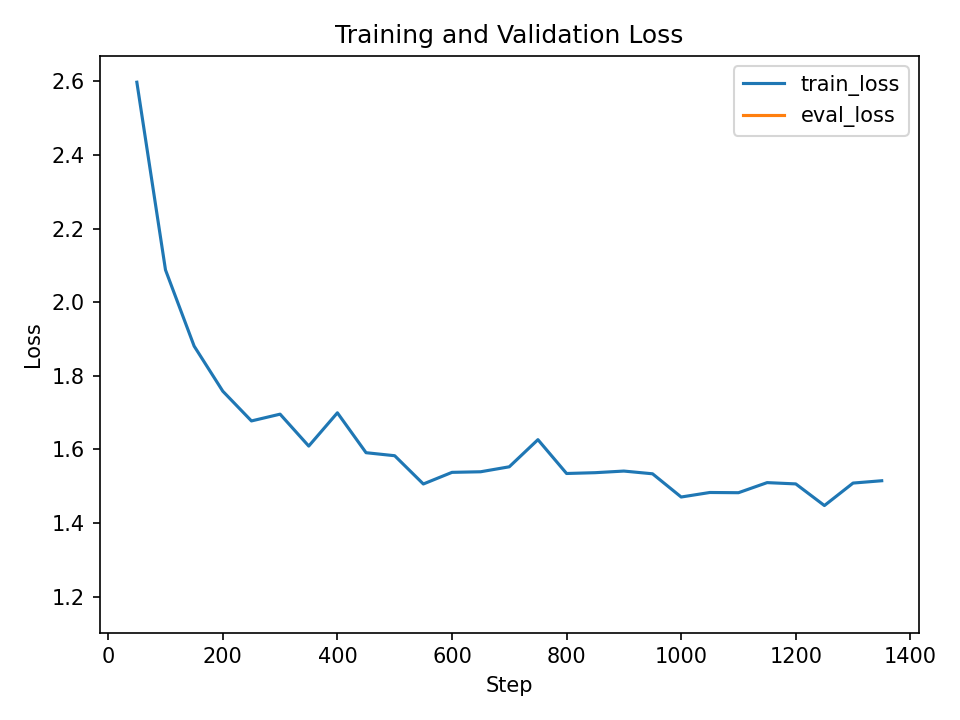

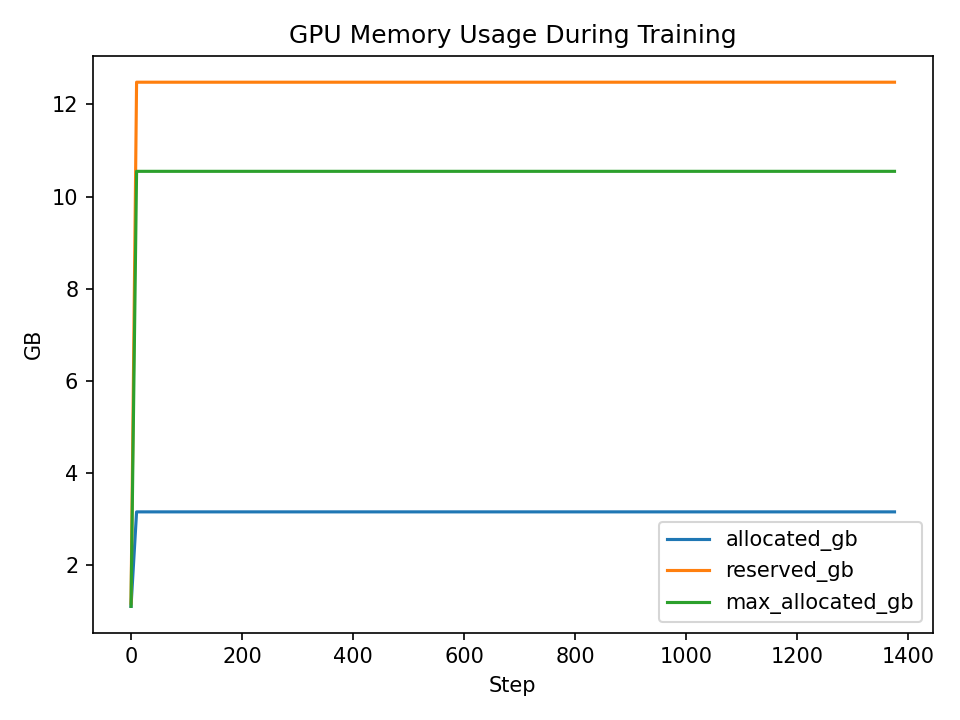

In [36]:
model_name = "google/long-t5-tglobal-base"

dataset_ids = [
    "xkristian/LegalDocumentSummarization"
]

hf_token = os.getenv("HUGGINGFACE_HUB_TOKEN")


for dataset_id in dataset_ids:
    pipeline(
        dataset_id=dataset_id,
        model_name=model_name,
        input_col="judgement",
        target_col="summary",
        hub_repo_name=f"xkristian/long5-{dataset_id.split('/')[-1]}",
        output_dir=f"longt5_finetuned_{dataset_id.split('/')[-1]}",
        hf_token=hf_token
    )